# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.2018, 0.2200, 0.2329,  ..., 0.0254, 0.1093, 0.1118],
         [0.2196, 0.2525, 0.2918,  ..., 0.0232, 0.1200, 0.1625],
         [0.2143, 0.2364, 0.3264,  ..., 0.0211, 0.1132, 0.1975],
         ...,
         [0.2050, 0.1861, 0.1686,  ..., 0.1861, 0.1939, 0.2064],
         [0.1939, 0.1989, 0.1754,  ..., 0.1796, 0.1832, 0.2061],
         [0.2129, 0.2268, 0.1811,  ..., 0.1593, 0.1686, 0.1993]],

        [[0.3016, 0.3197, 0.3314,  ..., 0.0391, 0.1237, 0.1198],
         [0.3161, 0.3492, 0.3871,  ..., 0.0376, 0.1388, 0.1728],
         [0.3101, 0.3302, 0.4154,  ..., 0.0355, 0.1337, 0.2089],
         ...,
         [0.2044, 0.1845, 0.1653,  ..., 0.2035, 0.2110, 0.2200],
         [0.1945, 0.1978, 0.1719,  ..., 0.1978, 0.1981, 0.2185],
         [0.2119, 0.2219, 0.1737,  ..., 0.1788, 0.1854, 0.2128]],

        [[0.2525, 0.2725, 0.2867,  ..., 0.0395, 0.1371, 0.1427],
         [0.2602, 0.3014, 0.3545,  ..., 0.0387, 0.1539, 0.2038],
         [0.2669, 0.2941, 0.4077,  ..., 0.0334, 0.1475, 0.

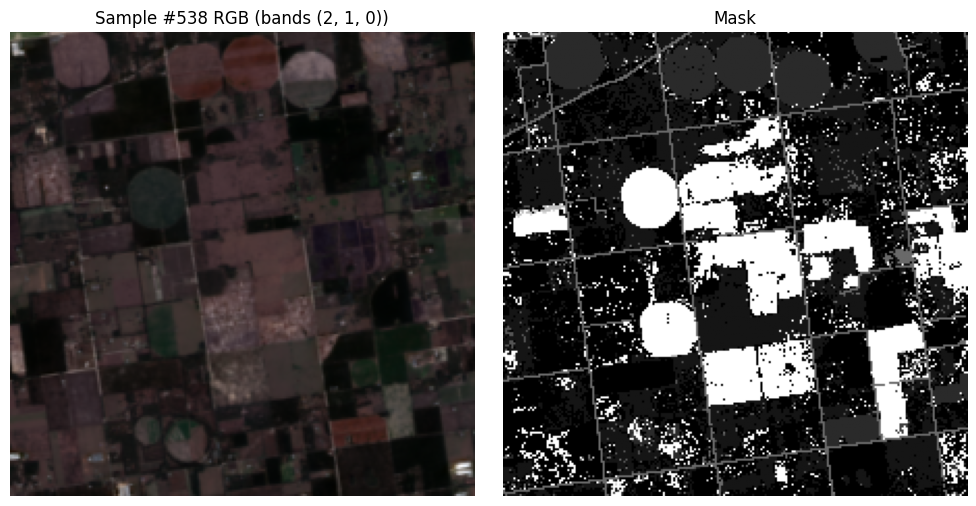

tensor([[[0.1555, 0.1236, 0.1042,  ..., 0.2348, 0.2189, 0.2103],
         [0.1260, 0.1054, 0.0828,  ..., 0.1509, 0.1672, 0.1594],
         [0.0828, 0.0828, 0.0875,  ..., 0.2014, 0.1610, 0.1318],
         ...,
         [0.2488, 0.2551, 0.2624,  ..., 0.1893, 0.1446, 0.1722],
         [0.2407, 0.2819, 0.2893,  ..., 0.2484, 0.2842, 0.2492],
         [0.2481, 0.2897, 0.2461,  ..., 0.2582, 0.2640, 0.2543]],

        [[0.1767, 0.1393, 0.1138,  ..., 0.2947, 0.2734, 0.2619],
         [0.1494, 0.1215, 0.0845,  ..., 0.1735, 0.1987, 0.1868],
         [0.0859, 0.0852, 0.0908,  ..., 0.2284, 0.1767, 0.1390],
         ...,
         [0.3188, 0.3268, 0.3352,  ..., 0.2392, 0.1833, 0.2168],
         [0.3135, 0.3673, 0.3684,  ..., 0.3310, 0.3698, 0.3111],
         [0.3212, 0.3764, 0.3261,  ..., 0.3366, 0.3558, 0.3464]],

        [[0.2338, 0.1749, 0.1369,  ..., 0.3613, 0.3282, 0.3150],
         [0.1930, 0.1509, 0.1003,  ..., 0.2188, 0.2432, 0.2258],
         [0.0979, 0.0937, 0.1052,  ..., 0.2969, 0.2300, 0.

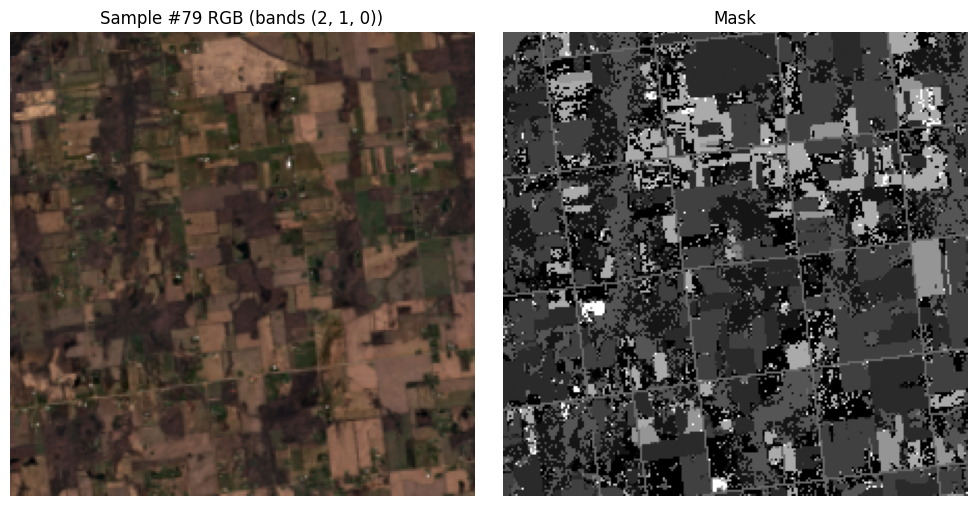

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = UnetPlusPlus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

dice_loss = DiceLoss(mode="multiclass", from_logits=True)
focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    # DiceLoss will internally one-hot `targets`
    L_dice  = dice_loss(preds, targets)
    # FocalLoss expects integer class labels
    L_focal = focal_loss(preds, targets)
    L_ce = ce_loss(preds, targets)

    return 1 * L_ce


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-7-1b0310b2e68a>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [17:10<00:00, 13.22s/it]


[Epoch  0] Loss:  2.2156, Acc:   0.1526, IoU:   0.0858, Dice:  0.0756, mIoU:  0.0516


Epoch 1/50 [Val]: 100%|██████████| 20/20 [02:27<00:00,  7.35s/it]


[Epoch  0] Loss: 2.0110, Acc: 0.2086, IoU: 0.1239, Dice: 0.1060, mIoU: 0.0765


Epoch 2/50: 100%|██████████| 78/78 [11:01<00:00,  8.48s/it]


[Epoch  1] Loss:  1.9226, Acc:   0.2261, IoU:   0.1375, Dice:  0.1195, mIoU:  0.0872


Epoch 2/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.62s/it]


[Epoch  1] Loss: 1.8796, Acc: 0.2397, IoU: 0.1438, Dice: 0.1259, mIoU: 0.0930


Epoch 3/50: 100%|██████████| 78/78 [10:24<00:00,  8.01s/it]


[Epoch  2] Loss:  1.8187, Acc:   0.2535, IoU:   0.1586, Dice:  0.1371, mIoU:  0.1021


Epoch 3/50 [Val]: 100%|██████████| 20/20 [02:18<00:00,  6.94s/it]


[Epoch  2] Loss: 1.7928, Acc: 0.2730, IoU: 0.1713, Dice: 0.1476, mIoU: 0.1102


Epoch 4/50: 100%|██████████| 78/78 [10:31<00:00,  8.10s/it]


[Epoch  3] Loss:  1.7591, Acc:   0.2683, IoU:   0.1708, Dice:  0.1487, mIoU:  0.1120


Epoch 4/50 [Val]: 100%|██████████| 20/20 [02:14<00:00,  6.70s/it]


[Epoch  3] Loss: 1.7338, Acc: 0.2953, IoU: 0.1845, Dice: 0.1609, mIoU: 0.1219


Epoch 5/50: 100%|██████████| 78/78 [09:52<00:00,  7.59s/it]


[Epoch  4] Loss:  1.6939, Acc:   0.2939, IoU:   0.1929, Dice:  0.1646, mIoU:  0.1253


Epoch 5/50 [Val]: 100%|██████████| 20/20 [02:13<00:00,  6.67s/it]


[Epoch  4] Loss: 1.6743, Acc: 0.3097, IoU: 0.2038, Dice: 0.1748, mIoU: 0.1344


Epoch 6/50: 100%|██████████| 78/78 [10:40<00:00,  8.22s/it]


[Epoch  5] Loss:  1.6444, Acc:   0.3118, IoU:   0.2066, Dice:  0.1755, mIoU:  0.1353


Epoch 6/50 [Val]: 100%|██████████| 20/20 [02:41<00:00,  8.06s/it]


[Epoch  5] Loss: 1.6518, Acc: 0.3000, IoU: 0.1952, Dice: 0.1752, mIoU: 0.1367


Epoch 7/50: 100%|██████████| 78/78 [09:37<00:00,  7.40s/it]


[Epoch  6] Loss:  1.6065, Acc:   0.3250, IoU:   0.2167, Dice:  0.1841, mIoU:  0.1438


Epoch 7/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.58s/it]


[Epoch  6] Loss: 1.6283, Acc: 0.3165, IoU: 0.2115, Dice: 0.1843, mIoU: 0.1431


Epoch 8/50: 100%|██████████| 78/78 [10:05<00:00,  7.76s/it]


[Epoch  7] Loss:  1.5897, Acc:   0.3318, IoU:   0.2223, Dice:  0.1895, mIoU:  0.1486


Epoch 8/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.64s/it]


[Epoch  7] Loss: 1.5928, Acc: 0.3221, IoU: 0.2150, Dice: 0.1845, mIoU: 0.1453


Epoch 9/50: 100%|██████████| 78/78 [09:27<00:00,  7.27s/it]


[Epoch  8] Loss:  1.5479, Acc:   0.3687, IoU:   0.2492, Dice:  0.1960, mIoU:  0.1558


Epoch 9/50 [Val]: 100%|██████████| 20/20 [02:48<00:00,  8.45s/it]


[Epoch  8] Loss: 1.5490, Acc: 0.3641, IoU: 0.2449, Dice: 0.1971, mIoU: 0.1567


Epoch 10/50: 100%|██████████| 78/78 [09:29<00:00,  7.30s/it]


[Epoch  9] Loss:  1.5005, Acc:   0.3846, IoU:   0.2621, Dice:  0.2041, mIoU:  0.1629


Epoch 10/50 [Val]: 100%|██████████| 20/20 [02:13<00:00,  6.69s/it]


[Epoch  9] Loss: 1.5312, Acc: 0.3851, IoU: 0.2577, Dice: 0.2006, mIoU: 0.1587


Epoch 11/50: 100%|██████████| 78/78 [09:56<00:00,  7.65s/it]


[Epoch 10] Loss:  1.4819, Acc:   0.3982, IoU:   0.2748, Dice:  0.2095, mIoU:  0.1674


Epoch 11/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


[Epoch 10] Loss: 1.4949, Acc: 0.3871, IoU: 0.2664, Dice: 0.2066, mIoU: 0.1645


Epoch 12/50: 100%|██████████| 78/78 [09:09<00:00,  7.04s/it]


[Epoch 11] Loss:  1.4587, Acc:   0.4130, IoU:   0.2882, Dice:  0.2158, mIoU:  0.1729


Epoch 12/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.21s/it]


[Epoch 11] Loss: 1.5326, Acc: 0.3794, IoU: 0.2659, Dice: 0.2043, mIoU: 0.1634


Epoch 13/50: 100%|██████████| 78/78 [09:03<00:00,  6.97s/it]


[Epoch 12] Loss:  1.4178, Acc:   0.4271, IoU:   0.3006, Dice:  0.2219, mIoU:  0.1793


Epoch 13/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 12] Loss: 1.4679, Acc: 0.3992, IoU: 0.2816, Dice: 0.2138, mIoU: 0.1735


Epoch 14/50: 100%|██████████| 78/78 [09:02<00:00,  6.95s/it]


[Epoch 13] Loss:  1.4119, Acc:   0.4363, IoU:   0.3081, Dice:  0.2262, mIoU:  0.1843


Epoch 14/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


[Epoch 13] Loss: 1.5206, Acc: 0.3655, IoU: 0.2547, Dice: 0.2098, mIoU: 0.1736


Epoch 15/50: 100%|██████████| 78/78 [09:43<00:00,  7.48s/it]


[Epoch 14] Loss:  1.3939, Acc:   0.4425, IoU:   0.3132, Dice:  0.2282, mIoU:  0.1869


Epoch 15/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


[Epoch 14] Loss: 1.4758, Acc: 0.4207, IoU: 0.2967, Dice: 0.2201, mIoU: 0.1799


Epoch 16/50: 100%|██████████| 78/78 [09:08<00:00,  7.03s/it]


[Epoch 15] Loss:  1.3796, Acc:   0.4527, IoU:   0.3213, Dice:  0.2317, mIoU:  0.1912


Epoch 16/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.17s/it]


[Epoch 15] Loss: 1.4712, Acc: 0.4393, IoU: 0.3030, Dice: 0.2224, mIoU: 0.1778


Epoch 17/50: 100%|██████████| 78/78 [08:58<00:00,  6.90s/it]


[Epoch 16] Loss:  1.3583, Acc:   0.4622, IoU:   0.3286, Dice:  0.2360, mIoU:  0.1956


Epoch 17/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.12s/it]


[Epoch 16] Loss: 1.3978, Acc: 0.4559, IoU: 0.3209, Dice: 0.2307, mIoU: 0.1887


Epoch 18/50: 100%|██████████| 78/78 [09:01<00:00,  6.94s/it]


[Epoch 17] Loss:  1.3483, Acc:   0.4662, IoU:   0.3323, Dice:  0.2378, mIoU:  0.1979


Epoch 18/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


[Epoch 17] Loss: 1.4208, Acc: 0.4423, IoU: 0.3104, Dice: 0.2303, mIoU: 0.1908


Epoch 19/50: 100%|██████████| 78/78 [09:06<00:00,  7.01s/it]


[Epoch 18] Loss:  1.3155, Acc:   0.4795, IoU:   0.3435, Dice:  0.2436, mIoU:  0.2045


Epoch 19/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.30s/it]


[Epoch 18] Loss: 1.3894, Acc: 0.4581, IoU: 0.3201, Dice: 0.2359, mIoU: 0.1964


Epoch 20/50: 100%|██████████| 78/78 [09:48<00:00,  7.54s/it]


[Epoch 19] Loss:  1.3058, Acc:   0.4875, IoU:   0.3494, Dice:  0.2466, mIoU:  0.2079


Epoch 20/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 19] Loss: 1.4254, Acc: 0.4486, IoU: 0.3154, Dice: 0.2299, mIoU: 0.1906


Epoch 21/50: 100%|██████████| 78/78 [09:02<00:00,  6.95s/it]


[Epoch 20] Loss:  1.3091, Acc:   0.4873, IoU:   0.3495, Dice:  0.2473, mIoU:  0.2086


Epoch 21/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


[Epoch 20] Loss: 1.3706, Acc: 0.4609, IoU: 0.3313, Dice: 0.2374, mIoU: 0.2001


Epoch 22/50: 100%|██████████| 78/78 [09:37<00:00,  7.40s/it]


[Epoch 21] Loss:  1.2940, Acc:   0.4930, IoU:   0.3538, Dice:  0.2485, mIoU:  0.2108


Epoch 22/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.20s/it]


[Epoch 21] Loss: 1.3382, Acc: 0.4833, IoU: 0.3412, Dice: 0.2442, mIoU: 0.2070


Epoch 23/50: 100%|██████████| 78/78 [09:06<00:00,  7.01s/it]


[Epoch 22] Loss:  1.2863, Acc:   0.4974, IoU:   0.3574, Dice:  0.2517, mIoU:  0.2140


Epoch 23/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.40s/it]


[Epoch 22] Loss: 1.3497, Acc: 0.4819, IoU: 0.3436, Dice: 0.2458, mIoU: 0.2074


Epoch 24/50: 100%|██████████| 78/78 [09:24<00:00,  7.24s/it]


[Epoch 23] Loss:  1.2674, Acc:   0.5033, IoU:   0.3627, Dice:  0.2547, mIoU:  0.2172


Epoch 24/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.30s/it]


[Epoch 23] Loss: 1.3800, Acc: 0.4613, IoU: 0.3304, Dice: 0.2432, mIoU: 0.2072


Epoch 25/50: 100%|██████████| 78/78 [09:21<00:00,  7.20s/it]


[Epoch 24] Loss:  1.2575, Acc:   0.5080, IoU:   0.3665, Dice:  0.2571, mIoU:  0.2203


Epoch 25/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch 24] Loss: 1.4637, Acc: 0.4421, IoU: 0.3114, Dice: 0.2304, mIoU: 0.1922


Epoch 26/50: 100%|██████████| 78/78 [09:01<00:00,  6.95s/it]


[Epoch 25] Loss:  1.2598, Acc:   0.5104, IoU:   0.3685, Dice:  0.2582, mIoU:  0.2214


Epoch 26/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


[Epoch 25] Loss: 1.3770, Acc: 0.4991, IoU: 0.3375, Dice: 0.2432, mIoU: 0.2039


Epoch 27/50: 100%|██████████| 78/78 [09:02<00:00,  6.96s/it]


[Epoch 26] Loss:  1.2381, Acc:   0.5157, IoU:   0.3729, Dice:  0.2605, mIoU:  0.2245


Epoch 27/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.35s/it]


[Epoch 26] Loss: 1.2978, Acc: 0.5087, IoU: 0.3537, Dice: 0.2559, mIoU: 0.2190


Epoch 28/50: 100%|██████████| 78/78 [09:12<00:00,  7.09s/it]


[Epoch 27] Loss:  1.2206, Acc:   0.5230, IoU:   0.3790, Dice:  0.2638, mIoU:  0.2284


Epoch 28/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.32s/it]


[Epoch 27] Loss: 1.2869, Acc: 0.4955, IoU: 0.3523, Dice: 0.2558, mIoU: 0.2205


Epoch 29/50: 100%|██████████| 78/78 [09:14<00:00,  7.11s/it]


[Epoch 28] Loss:  1.2142, Acc:   0.5257, IoU:   0.3813, Dice:  0.2653, mIoU:  0.2300


Epoch 29/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


[Epoch 28] Loss: 1.2912, Acc: 0.4976, IoU: 0.3573, Dice: 0.2585, mIoU: 0.2226


Epoch 30/50: 100%|██████████| 78/78 [08:59<00:00,  6.92s/it]


[Epoch 29] Loss:  1.2067, Acc:   0.5300, IoU:   0.3858, Dice:  0.2680, mIoU:  0.2325


Epoch 30/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


[Epoch 29] Loss: 1.2902, Acc: 0.5045, IoU: 0.3533, Dice: 0.2527, mIoU: 0.2164


Epoch 31/50: 100%|██████████| 78/78 [09:04<00:00,  6.98s/it]


[Epoch 30] Loss:  1.1969, Acc:   0.5340, IoU:   0.3889, Dice:  0.2694, mIoU:  0.2343


Epoch 31/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.44s/it]


[Epoch 30] Loss: 1.3195, Acc: 0.4874, IoU: 0.3517, Dice: 0.2485, mIoU: 0.2142


Epoch 32/50: 100%|██████████| 78/78 [09:09<00:00,  7.05s/it]


[Epoch 31] Loss:  1.1887, Acc:   0.5365, IoU:   0.3909, Dice:  0.2705, mIoU:  0.2361


Epoch 32/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


[Epoch 31] Loss: 1.2988, Acc: 0.5052, IoU: 0.3629, Dice: 0.2523, mIoU: 0.2172


Epoch 33/50: 100%|██████████| 78/78 [09:21<00:00,  7.19s/it]


[Epoch 32] Loss:  1.1934, Acc:   0.5389, IoU:   0.3924, Dice:  0.2718, mIoU:  0.2373


Epoch 33/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


[Epoch 32] Loss: 1.3244, Acc: 0.4983, IoU: 0.3459, Dice: 0.2489, mIoU: 0.2126


Epoch 34/50: 100%|██████████| 78/78 [08:56<00:00,  6.88s/it]


[Epoch 33] Loss:  1.1994, Acc:   0.5372, IoU:   0.3913, Dice:  0.2706, mIoU:  0.2359


Epoch 34/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.32s/it]


[Epoch 33] Loss: 1.4570, Acc: 0.4427, IoU: 0.3028, Dice: 0.2336, mIoU: 0.1979


Epoch 35/50: 100%|██████████| 78/78 [09:43<00:00,  7.49s/it]


[Epoch 34] Loss:  1.2074, Acc:   0.5323, IoU:   0.3827, Dice:  0.2665, mIoU:  0.2319


Epoch 35/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.44s/it]


[Epoch 34] Loss: 1.2471, Acc: 0.5090, IoU: 0.3717, Dice: 0.2613, mIoU: 0.2287


Epoch 36/50: 100%|██████████| 78/78 [09:41<00:00,  7.45s/it]


[Epoch 35] Loss:  1.1580, Acc:   0.5515, IoU:   0.4057, Dice:  0.2779, mIoU:  0.2450


Epoch 36/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.30s/it]


[Epoch 35] Loss: 1.2490, Acc: 0.5302, IoU: 0.3744, Dice: 0.2674, mIoU: 0.2312


Epoch 37/50: 100%|██████████| 78/78 [09:34<00:00,  7.36s/it]


[Epoch 36] Loss:  1.1622, Acc:   0.5483, IoU:   0.4015, Dice:  0.2772, mIoU:  0.2435


Epoch 37/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.26s/it]


[Epoch 36] Loss: 1.2368, Acc: 0.5340, IoU: 0.3801, Dice: 0.2694, mIoU: 0.2340


Epoch 38/50: 100%|██████████| 78/78 [08:53<00:00,  6.84s/it]


[Epoch 37] Loss:  1.1376, Acc:   0.5583, IoU:   0.4106, Dice:  0.2807, mIoU:  0.2476


Epoch 38/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.40s/it]


[Epoch 37] Loss: 1.2070, Acc: 0.5249, IoU: 0.3832, Dice: 0.2704, mIoU: 0.2365


Epoch 39/50: 100%|██████████| 78/78 [09:06<00:00,  7.01s/it]


[Epoch 38] Loss:  1.1321, Acc:   0.5600, IoU:   0.4130, Dice:  0.2826, mIoU:  0.2499


Epoch 39/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 38] Loss: 1.2270, Acc: 0.5304, IoU: 0.3821, Dice: 0.2677, mIoU: 0.2347


Epoch 40/50: 100%|██████████| 78/78 [09:04<00:00,  6.98s/it]


[Epoch 39] Loss:  1.1265, Acc:   0.5625, IoU:   0.4143, Dice:  0.2828, mIoU:  0.2503


Epoch 40/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


[Epoch 39] Loss: 1.2143, Acc: 0.5299, IoU: 0.3826, Dice: 0.2726, mIoU: 0.2382


Epoch 41/50: 100%|██████████| 78/78 [09:41<00:00,  7.46s/it]


[Epoch 40] Loss:  1.1167, Acc:   0.5671, IoU:   0.4192, Dice:  0.2858, mIoU:  0.2534


Epoch 41/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


[Epoch 40] Loss: 1.2206, Acc: 0.5223, IoU: 0.3807, Dice: 0.2707, mIoU: 0.2373


Epoch 42/50: 100%|██████████| 78/78 [08:52<00:00,  6.83s/it]


[Epoch 41] Loss:  1.1245, Acc:   0.5622, IoU:   0.4149, Dice:  0.2843, mIoU:  0.2510


Epoch 42/50 [Val]: 100%|██████████| 20/20 [02:01<00:00,  6.07s/it]


[Epoch 41] Loss: 1.2192, Acc: 0.5193, IoU: 0.3788, Dice: 0.2698, mIoU: 0.2367


Epoch 43/50: 100%|██████████| 78/78 [09:26<00:00,  7.26s/it]


[Epoch 42] Loss:  1.1146, Acc:   0.5667, IoU:   0.4189, Dice:  0.2854, mIoU:  0.2532


Epoch 43/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.57s/it]


[Epoch 42] Loss: 1.2100, Acc: 0.5293, IoU: 0.3828, Dice: 0.2708, mIoU: 0.2371


Epoch 44/50: 100%|██████████| 78/78 [09:47<00:00,  7.53s/it]


[Epoch 43] Loss:  1.1070, Acc:   0.5695, IoU:   0.4218, Dice:  0.2868, mIoU:  0.2547


Epoch 44/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


[Epoch 43] Loss: 1.2115, Acc: 0.5261, IoU: 0.3832, Dice: 0.2730, mIoU: 0.2384


Epoch 45/50: 100%|██████████| 78/78 [09:26<00:00,  7.26s/it]


[Epoch 44] Loss:  1.0902, Acc:   0.5769, IoU:   0.4289, Dice:  0.2903, mIoU:  0.2587


Epoch 45/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.53s/it]


[Epoch 44] Loss: 1.1927, Acc: 0.5329, IoU: 0.3891, Dice: 0.2751, mIoU: 0.2426


Epoch 46/50: 100%|██████████| 78/78 [09:48<00:00,  7.55s/it]


[Epoch 45] Loss:  1.0982, Acc:   0.5796, IoU:   0.4311, Dice:  0.2915, mIoU:  0.2600


Epoch 46/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.47s/it]


[Epoch 45] Loss: 1.2048, Acc: 0.5418, IoU: 0.3884, Dice: 0.2746, mIoU: 0.2405


Epoch 47/50: 100%|██████████| 78/78 [09:10<00:00,  7.05s/it]


[Epoch 46] Loss:  1.0979, Acc:   0.5761, IoU:   0.4279, Dice:  0.2907, mIoU:  0.2588


Epoch 47/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.32s/it]


[Epoch 46] Loss: 1.1990, Acc: 0.5323, IoU: 0.3888, Dice: 0.2758, mIoU: 0.2423


Epoch 48/50: 100%|██████████| 78/78 [09:53<00:00,  7.61s/it]


[Epoch 47] Loss:  1.0887, Acc:   0.5792, IoU:   0.4298, Dice:  0.2914, mIoU:  0.2594


Epoch 48/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch 47] Loss: 1.1908, Acc: 0.5301, IoU: 0.3911, Dice: 0.2741, mIoU: 0.2416


Epoch 49/50: 100%|██████████| 78/78 [09:33<00:00,  7.35s/it]


[Epoch 48] Loss:  1.0876, Acc:   0.5814, IoU:   0.4324, Dice:  0.2923, mIoU:  0.2608


Epoch 49/50 [Val]: 100%|██████████| 20/20 [01:53<00:00,  5.68s/it]


[Epoch 48] Loss: 1.1941, Acc: 0.5355, IoU: 0.3904, Dice: 0.2752, mIoU: 0.2420


Epoch 50/50: 100%|██████████| 78/78 [10:01<00:00,  7.71s/it]


[Epoch 49] Loss:  1.0798, Acc:   0.5824, IoU:   0.4337, Dice:  0.2926, mIoU:  0.2611


Epoch 50/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


[Epoch 49] Loss: 1.1887, Acc: 0.5364, IoU: 0.3915, Dice: 0.2757, mIoU: 0.2431


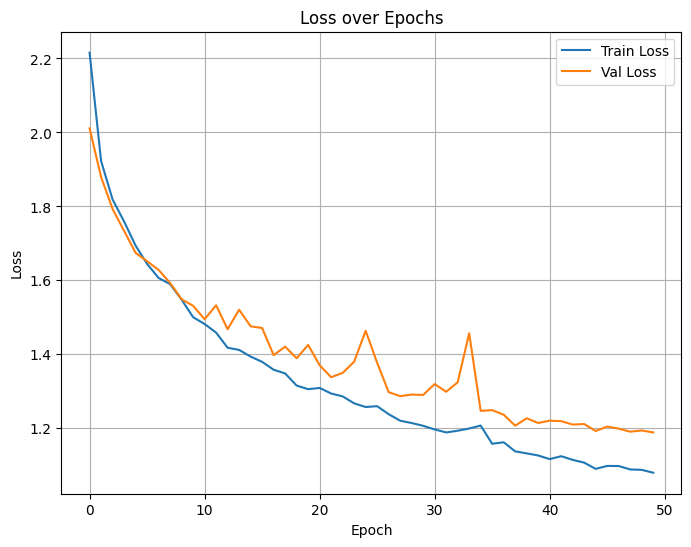

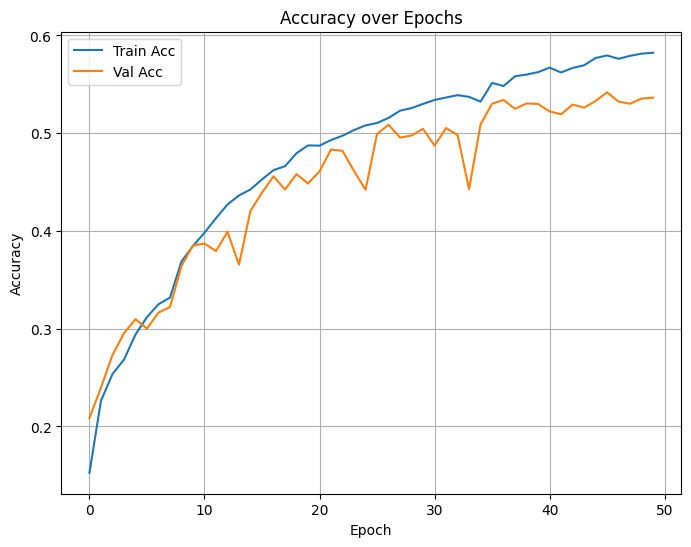

In [ ]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(accuracy.compute().item())
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_loss_20250520-050013_normalized_ce.png


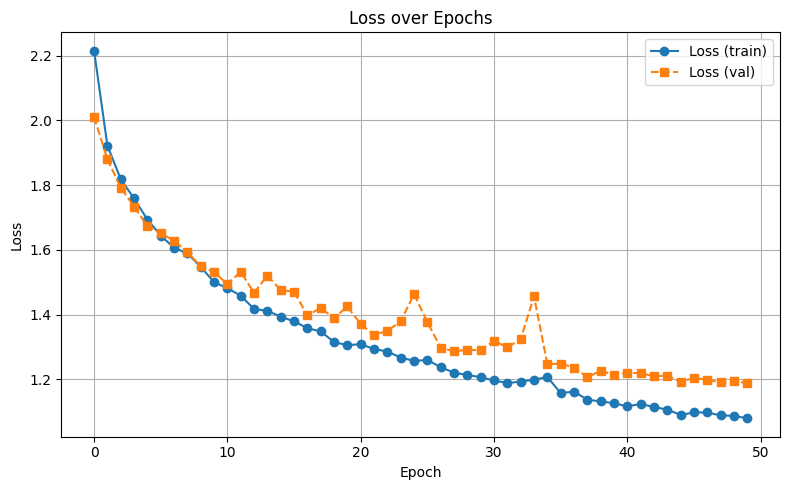

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250520-050013_normalized_ce.png


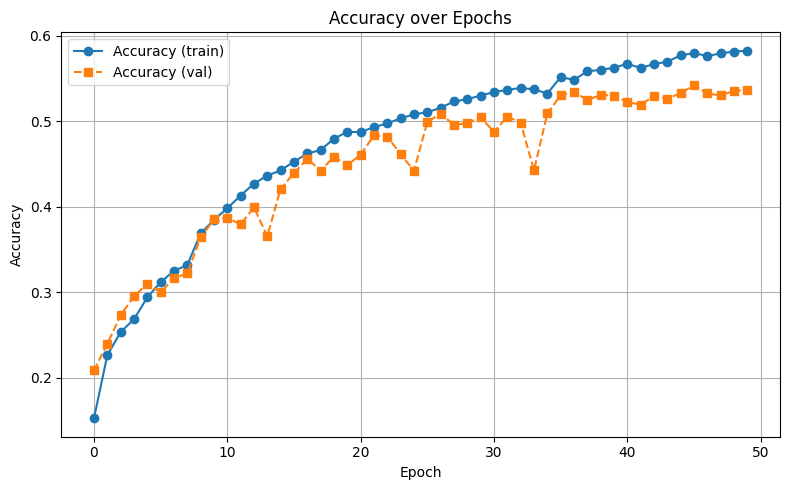

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_iou_20250520-050013_normalized_ce.png


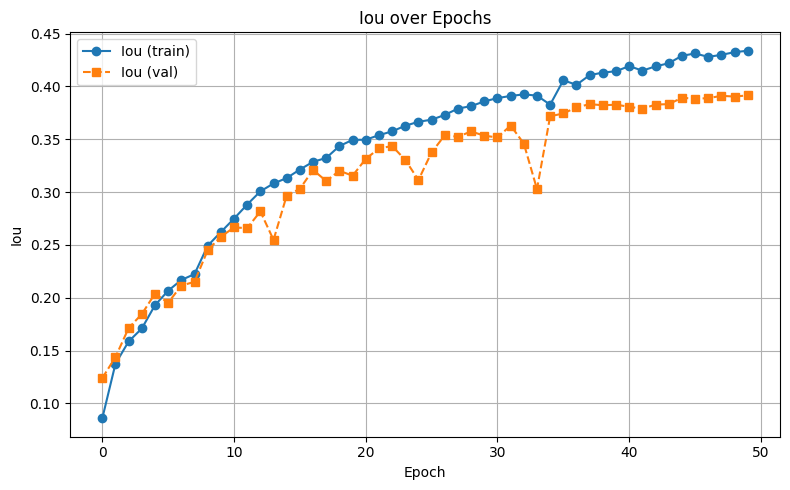

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_dice_20250520-050013_normalized_ce.png


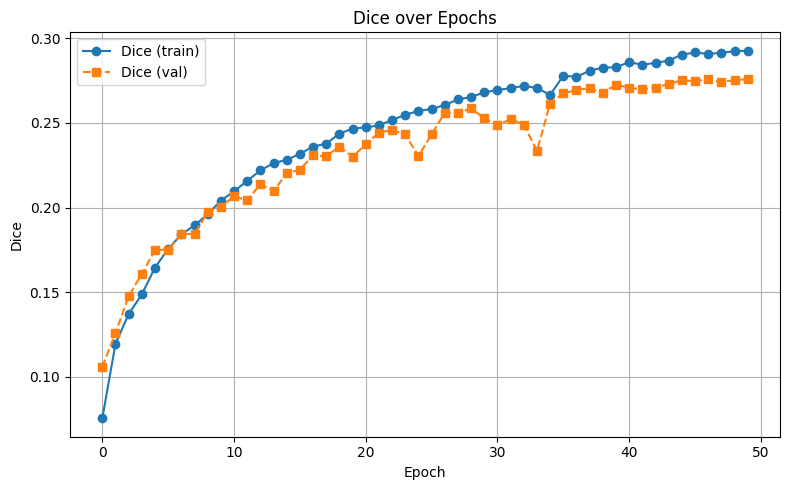

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_miou_20250520-050013_normalized_ce.png


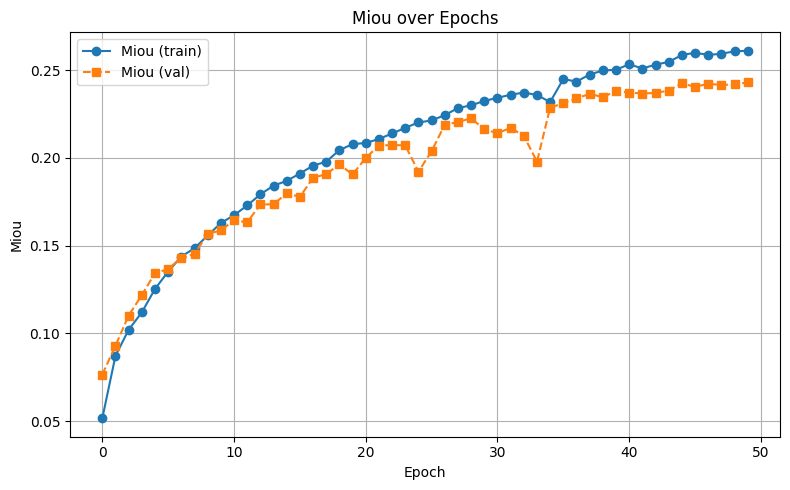

In [ ]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_ce.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [ ]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_ce.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_ce.pth


In [ ]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_ce_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_ce_metrics.csv
